In [209]:
import pandas as pd
import os
from scipy.stats import skew, kurtosis
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_from_order_func
from optimizers.utils._utils import get_csv_data
from optimizers.cross_validators import vbt_cv_sliding_constructor
from optimizers.pipes.pipe import SQLPipe

load_dotenv()

USER = os.getenv('psql_username')
PASS = os.getenv('psql_password')
DATABASE = 'crypto'
SCHEMA = 'kucoin'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS)

In [226]:
assets = ['CAKE-USDT', 'AAVE-USDT']
slicer = 0 # Slice off first few months of trading to reduce early volatility

df = pipe.query_pairs_trading_backtest(assets)
closes = df.xs('close', level=1, axis=1)[slicer:]
opens = df.xs('open', level=1, axis=1)[slicer:]
assert closes.shape[0] > 8640, 'Less than 1 year of backtesting data present'
assert closes.shape == opens.shape, 'Open and close shape does not match'

print(f"Full data length: {closes.shape[0]}")

train_opens, opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=3)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=3)

print(f"Test data length: {opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 13766
Test data length: 4130
Train fold length 3212


In [227]:
# EOS FIL works on a CUMMLOG model but has volatility in per trade returns
# FIL THETA & LINK CHZ, BTC ZEC. BTCZEC might work, but had generalization issues
# ADA ZEC is untestable due to massive regime shift mid test set for LOG model
# Something is bizarre and wrong with the ADA ZEC data; needs review?
# BSV 1INCH 70 2.1 -2.4 1.3 5.000000e-07 0.00030 CUMMLOG <- does not work past 10bps slippage
# XLM1INCH, LTCCHZ, DGBCAKE, NEODGB, DGBDASH, GRT1INCH failed backtesting
# THETA FIL 100 1.2 -1.2 0.3 9.e-8 4.e-5 LOG seems to work
# BATANKR 303 0.7 -2.7 0.4 3.e-9 1.7e-5 LOG
# LTCCHZ works, but apparently failed to hedge (same issue as with CHZWIN) <- this might be fixed now
# BNBTRX (LOG) failed
# BNBTRX CUMMLOG 615 1.9 -2.2 1.4 8e-6 0.3 <- low sharpe, but high WR. High duration. Deploy with minor alloc?
# XLM SUN / SUN XLM  does not generalize well. Low trade count, high duration
# XMR ETH failed across all models. Still need to test ETH XMR
# ASX VRA DEFAULT 20 2.0 -1.8 0.6 8e-8 1.2 <- extremely successful
# DOGE SUN / SUN DOGEfailed on all models
# FIL CAKE DEFAULT 510 1.6 -1.4 0.1 6e-6 7e-1 returned low trade count, high duration, but ~2 sharpe, high wr, high pr. Bears live testing
# THETA FIL LOG 355 1.5 -1.5 1.2 1E-9 0.15 works quite well at 20bps slippage. Fat tail risk in trades leads to low sharpe
# EOS CAKE does not work on any metric

PERIOD = 570
UPPER = 4.6
LOWER = -0.6
EXIT = 0.5
DELTA = 2e-9
VT = 9e-4
BURNIN = 800
MODEL = 'default'
HEDGE = 'beta'
SLIPPAGE = 0.0020
FREQ = "h"

In [228]:
pf = simulate_from_order_func(
    closes, opens,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq=FREQ,
    hedge=HEDGE,
    mode=MODEL,
    slippage=SLIPPAGE,
    order_size=0.10,
)

0.0006559869909779604


<AxesSubplot:xlabel='time'>

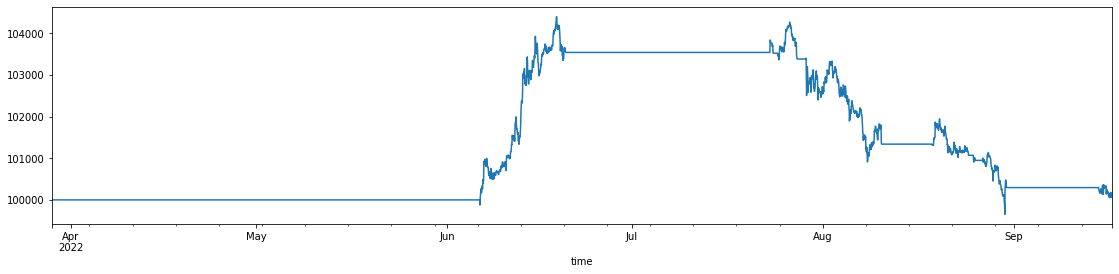

In [229]:
print(pf.total_return())
pf.value().plot(figsize=(19,4))

In [230]:
pnl = (pf.trades.records_readable.groupby('Entry Timestamp').sum().PnL.resample('D').sum())
val = pf.value().resample('D').asfreq().fillna(pf.value())
res = pd.concat([pnl, val], axis=1, keys=['pnl', 'val'])
res = res.fillna(0)
res['ret'] = res.pnl / res.val
Rf = (1 + 0) ** (1/365) - 1 # Daily risk free rate
Rp = res.ret.mean() # Daily portfolio return
STDp = res.ret.std() # Daily standard deviation of return
sharpe = ((Rp - 0) / STDp) * np.sqrt(365) # Annualized sharpe

In [231]:
res = pf.trades.records_readable.groupby("Entry Timestamp").sum()

print(f"Total trades: {res.shape[0]}")
print(f"Executed trades: {pf.trades.records_readable.shape[0]}")
print(f"Profit Ratio: {res.PnL[res.PnL > 0].mean() / np.abs(res.PnL[res.PnL < 0].mean()):.3f}")
print(f"Net long-short win rate: {res.PnL[res.PnL > 0].shape[0] / res.shape[0] * 100:.2f}%")
print(f"Median trade profit: {res.PnL.median():.2f}")
print(f"Mean trade profit: {res.PnL.mean():.2f}")
print(f"STD of trade profit: {res.PnL.std():.2f}")
print(f"Sharpe ratio: {sharpe:.4f}")

Total trades: 19
Executed trades: 38
Profit Ratio: 2.200
Net long-short win rate: 31.58%
Median trade profit: -122.73
Mean trade profit: 3.45
STD of trade profit: 924.05
Sharpe ratio: 0.0528


<AxesSubplot:xlabel='Entry Timestamp'>

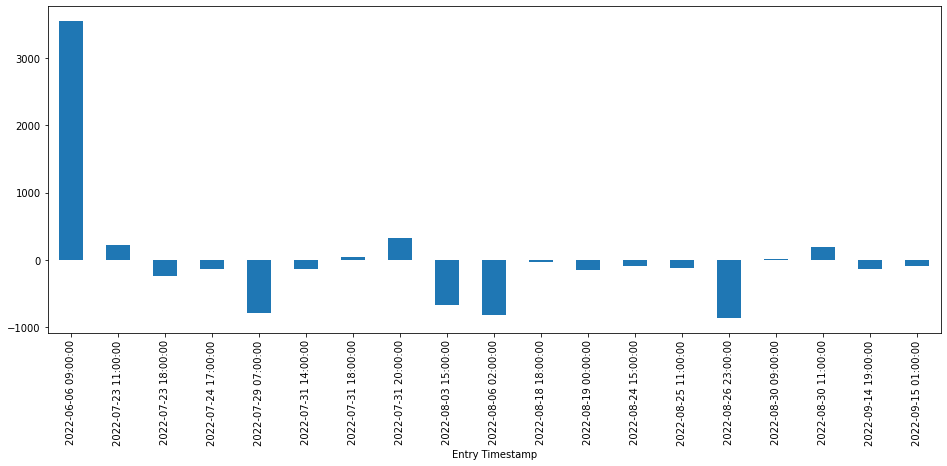

In [232]:
res.PnL.plot(kind="bar", figsize=(16,6))

Kurtosis: 6.190353933524482
Skew: 0.5200742475231072


<AxesSubplot:ylabel='Frequency'>

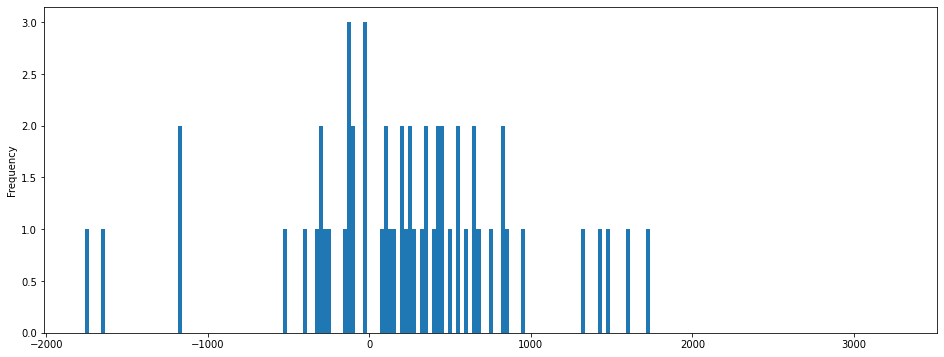

In [224]:
print(f'Kurtosis: {kurtosis(res.PnL, fisher=False)}')
print(f'Skew: {skew(res.PnL)}')

bins = np.arange(res.PnL.min(), res.PnL.max(), 25)
res.PnL.plot(kind="hist", figsize=(16,6), bins=bins)


In [225]:
pf.trades.records_readable.sort_values('Exit Fees')

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
56,56,AAVE-USDT,2.605176,2021-07-03 08:00:00,246.853304,0.514477,2021-07-04 05:00:00,263.566000,0.000000,-44.053987,-0.068503,Short,Open,56
113,113,CAKE-USDT,872.468676,2021-07-03 08:00:00,13.197342,9.211414,2021-07-04 05:00:00,13.839000,0.000000,550.615092,0.047820,Long,Open,113
23,23,AAVE-USDT,0.805124,2021-05-19 17:00:00,509.190348,0.327969,2021-05-20 01:00:00,369.945626,0.238282,-112.675505,-0.274844,Long,Closed,23
22,22,AAVE-USDT,0.766514,2021-05-19 05:00:00,562.480784,0.344919,2021-05-19 14:00:00,472.027170,0.289452,68.699558,0.159341,Short,Closed,22
25,25,AAVE-USDT,1.176378,2021-05-21 19:00:00,374.301108,0.352256,2021-05-21 21:00:00,335.636382,0.315868,-46.152443,-0.104816,Long,Closed,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,67,CAKE-USDT,279.850742,2021-04-28 11:00:00,35.578014,7.965227,2021-04-30 13:00:00,41.271292,9.239841,1576.063004,0.158294,Long,Closed,67
109,109,CAKE-USDT,864.699232,2021-06-23 07:00:00,13.259466,9.172360,2021-06-23 08:00:00,13.357232,9.239991,66.125834,0.005767,Long,Closed,109
106,106,CAKE-USDT,919.049418,2021-06-22 00:00:00,12.133218,8.920822,2021-06-22 03:00:00,12.882184,9.471491,669.944454,0.060079,Long,Closed,106
108,108,CAKE-USDT,915.958556,2021-06-22 19:00:00,12.439830,9.115495,2021-06-23 02:00:00,13.074798,9.580778,562.908099,0.049402,Long,Closed,108
